In [12]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [13]:
import pandas as pd
import numpy as np
import re  # regular expressions
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import missingno as msno
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [14]:
train = pd.read_csv("data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
test = pd.read_csv("data/test.csv")
PassengerId = test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived is well distributed

<Axes: ylabel='Survived'>

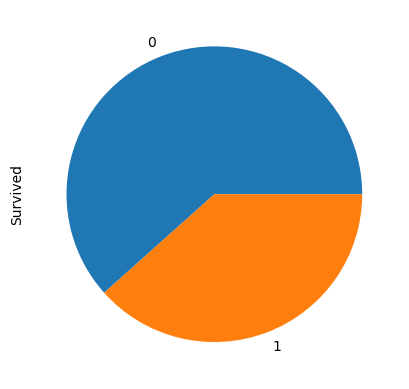

In [16]:
train.Survived.value_counts().plot(kind="pie")

<Axes: >

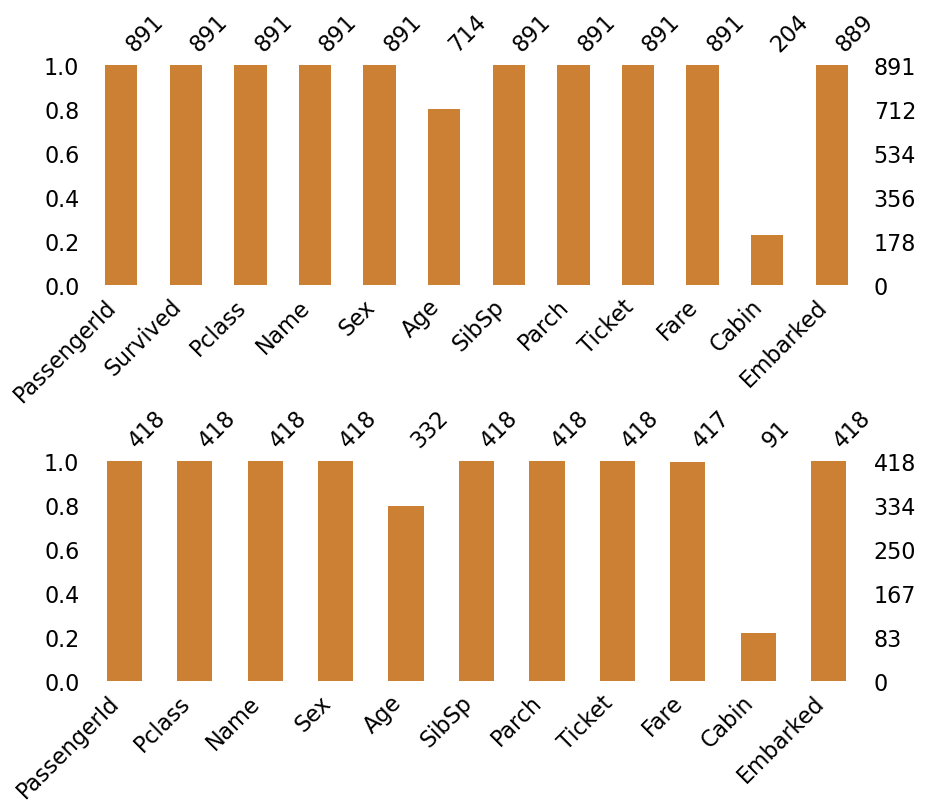

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.8)

msno.bar(df=train, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax1)
msno.bar(df=test, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax2)

In [18]:
def get_title(name):
    if re.search("([a-zA-Z]+)\.", name):
        return re.search("([a-zA-Z]+)\.", name)
    return

<Axes: ylabel='Sex'>

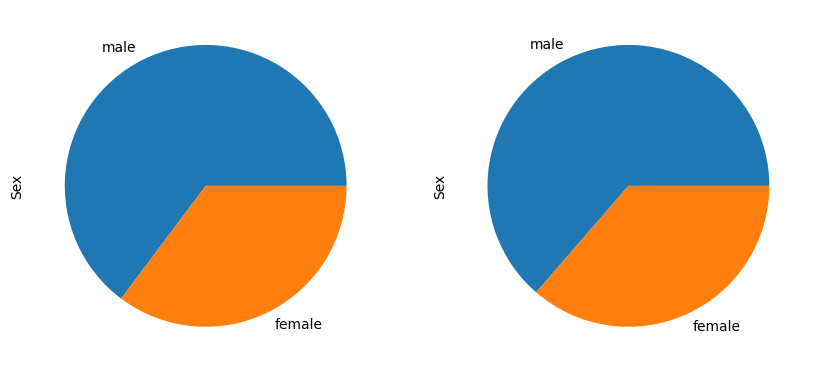

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
train.Sex.value_counts().plot(kind="pie", ax=ax1)
test.Sex.value_counts().plot(kind="pie", ax=ax2)

<Axes: ylabel='Density'>

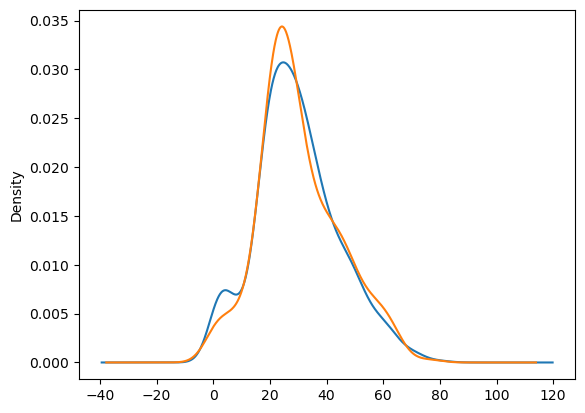

In [20]:
age_mean = train.Age.mean()
age_std = train.Age.std()
train.Age.plot(kind="kde")
test.Age.plot(kind="kde")

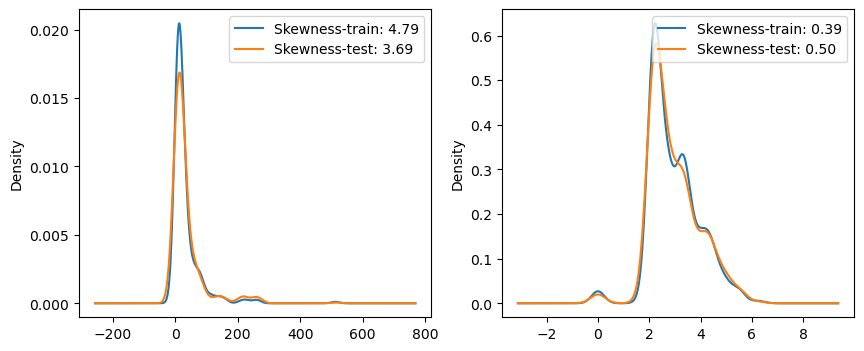

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
train.Fare.plot(kind="kde", ax=ax1)
test.Fare.plot(kind="kde", ax=ax1)

ax1.legend(
    [
        "Skewness-train: {:.2f}".format(train.Fare.skew()),
        "Skewness-test: {:.2f}".format(test.Fare.skew()),
    ]
)
train["Fare_log"] = train.Fare.apply(lambda x: np.log(x + 1) if x > 0 else 0)
test["Fare_log"] = train.Fare.apply(lambda x: np.log(x + 1) if x > 0 else 0)
train["Fare_log"].plot(kind="kde", ax=ax2)
test["Fare_log"].plot(kind="kde", ax=ax2)
ax2.legend(
    [
        "Skewness-train: {:.2f}".format(train.Fare_log.skew()),
        "Skewness-test: {:.2f}".format(test.Fare_log.skew()),
    ]
)

In [22]:
full_data = [train, test]

most_frequent_Embarked = train.Embarked.value_counts()[0]
median_Embarked = train.Fare.median()


for data in full_data:
    data["Sex"] = data.Sex.map({"male": 0, "female": 1})
    data["Title"] = data.Name.apply(get_title)
    data["Title"] = data.Title.replace(["Miss", "Mlle", "Lady"], "Ms")
    data["Title"] = data.Title.replace(
        ["Countess", "Mme", "Don", "Sir", "Capt", "Jonkheer"], "Mr"
    )

    age_null_size = data.Age.isnull().sum()
    ages_random = np.random.randint(
        age_mean - age_std, age_mean + age_std, age_null_size
    )
    data.Age[data.Age.isnull()] = ages_random

    data["FamilySize"] = data.SibSp + data.Parch + 1

    data["IsAlone"] = 0
    data["IsAlone"][data.FamilySize == 1] = 1

    data["HasCabin"] = [type(i) != float for i in data.Cabin]

    data["Embarked"][data.Embarked.isnull()] = most_frequent_Embarked

    data["Fare"][data.Fare.isnull()] = median_Embarked

In [23]:
y_train = train.Survived

In [24]:
X_train = train.drop(["Survived", "Cabin", "SibSp", "Parch", "Name"], axis=1)
X_test = test.drop(["Cabin", "SibSp", "Parch", "Name"], axis=1)

<Axes: >

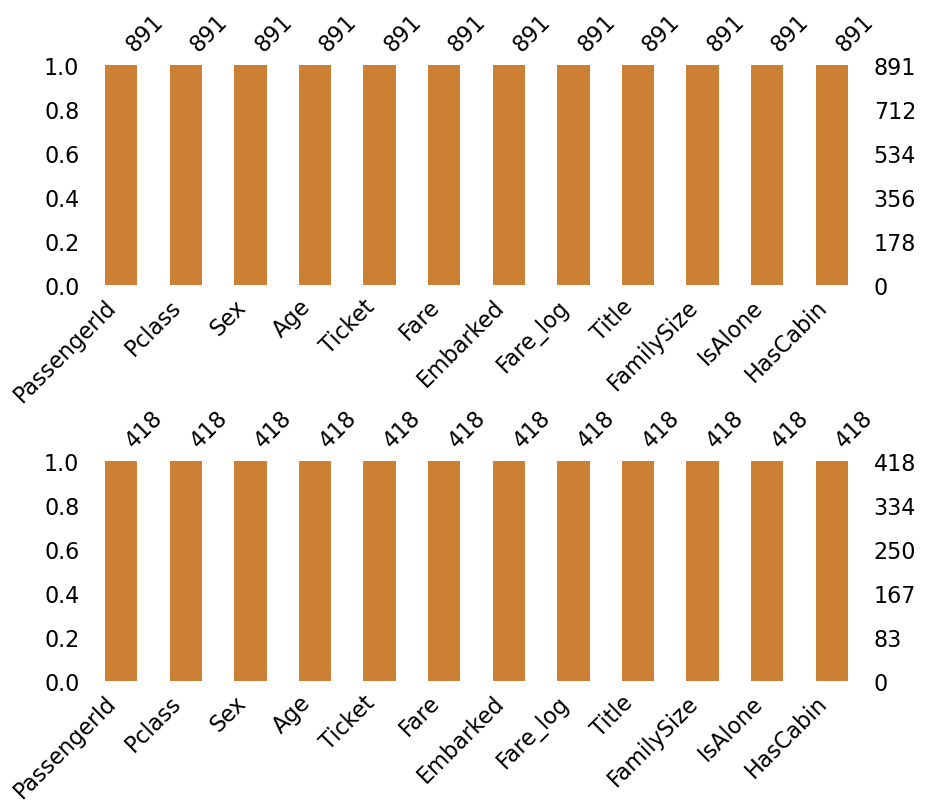

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.8)

msno.bar(df=X_train, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax1)
msno.bar(df=X_test, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax2)